In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Using device: NVIDIA GeForce RTX 2070 SUPER


In [3]:
# 2. Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

# Class names for CIFAR-10
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 3. Define CNN Model with Configurable Kernel and Pooling
class CNN(nn.Module):
    def __init__(self, kernel_size=3, pooling_type="max"):
        super(CNN, self).__init__()
        pooling_layer = nn.MaxPool2d if pooling_type == "max" else nn.AvgPool2d

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(32, 64, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(64, 128, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
# 4. Define Training and Testing Functions
def train_model(model, criterion, optimizer, train_loader, scheduler=None):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if scheduler:
        scheduler.step()
    return running_loss / len(train_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [6]:
# 5. Experiment Configurations
kernel_sizes = [3, 5, 7]
pooling_types = ["max", "avg"]
num_epochs_list = [5, 50, 100, 250, 350]
optimizers = {"SGD": optim.SGD, "RMSProp": optim.RMSprop, "Adam": optim.Adam}

# Store Results
results = {}

In [7]:
# 6. Experiment Loop
for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for opt_name, opt_class in optimizers.items():
            print(f"Kernel: {kernel_size}, Pooling: {pooling_type}, Optimizer: {opt_name}")
            
            # Initialize model, loss function, and optimizer
            model = CNN(kernel_size=kernel_size, pooling_type=pooling_type).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = opt_class(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

            epoch_accuracies = []

            for num_epochs in num_epochs_list:
                print(f"Training for {num_epochs} epochs")

                # Early Stopping Setup
                early_stop_counter = 0
                best_accuracy = 0
                patience = 5

                for epoch in range(num_epochs):
                    train_loss = train_model(model, criterion, optimizer, train_loader, scheduler)
                    test_accuracy = evaluate_model(model, test_loader)

                    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.4f}")

                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1

                    if early_stop_counter >= patience:
                        print("Early stopping triggered.")
                        break

                epoch_accuracies.append(best_accuracy)

            results[(kernel_size, pooling_type, opt_name)] = epoch_accuracies

Kernel: 3, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 1/5 - Loss: 2.3027, Accuracy: 0.1042


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 2/5 - Loss: 2.3025, Accuracy: 0.1042


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Epoch 3/5 - Loss: 2.3023, Accuracy: 0.1034


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/5 - Loss: 2.3021, Accuracy: 0.1031


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 5/5 - Loss: 2.3019, Accuracy: 0.1027
Training for 50 epochs


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 1/50 - Loss: 2.3017, Accuracy: 0.1021


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 2/50 - Loss: 2.3014, Accuracy: 0.1016


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 3/50 - Loss: 2.3012, Accuracy: 0.1012


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 4/50 - Loss: 2.3010, Accuracy: 0.1012


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/50 - Loss: 2.3008, Accuracy: 0.1011


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/50 - Loss: 2.3006, Accuracy: 0.1008
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/100 - Loss: 2.3004, Accuracy: 0.1007


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 2/100 - Loss: 2.3002, Accuracy: 0.1003


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 3/100 - Loss: 2.3000, Accuracy: 0.1001


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/100 - Loss: 2.2997, Accuracy: 0.1001


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/100 - Loss: 2.2995, Accuracy: 0.1001


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/100 - Loss: 2.2993, Accuracy: 0.1001
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/250 - Loss: 2.2991, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 2/250 - Loss: 2.2989, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/250 - Loss: 2.2986, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/250 - Loss: 2.2984, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 5/250 - Loss: 2.2982, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 6/250 - Loss: 2.2979, Accuracy: 0.1000
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/350 - Loss: 2.2977, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/350 - Loss: 2.2975, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 3/350 - Loss: 2.2972, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 4/350 - Loss: 2.2970, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 5/350 - Loss: 2.2967, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/350 - Loss: 2.2964, Accuracy: 0.1000
Early stopping triggered.
Kernel: 3, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/5 - Loss: 2.1159, Accuracy: 0.3974


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/5 - Loss: 1.6321, Accuracy: 0.4511


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/5 - Loss: 1.4575, Accuracy: 0.5180


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 4/5 - Loss: 1.3380, Accuracy: 0.5330


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 5/5 - Loss: 1.2513, Accuracy: 0.5613
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 1/50 - Loss: 1.1722, Accuracy: 0.5895


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/50 - Loss: 1.0974, Accuracy: 0.6001


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/50 - Loss: 1.0314, Accuracy: 0.6311


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/50 - Loss: 0.9934, Accuracy: 0.6173


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 5/50 - Loss: 0.9318, Accuracy: 0.6642


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/50 - Loss: 0.8981, Accuracy: 0.6524


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/50 - Loss: 0.8523, Accuracy: 0.6544


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/50 - Loss: 0.8206, Accuracy: 0.6825


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 9/50 - Loss: 0.7753, Accuracy: 0.6929


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 10/50 - Loss: 0.7377, Accuracy: 0.6899


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 11/50 - Loss: 0.7115, Accuracy: 0.6908


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 12/50 - Loss: 0.6747, Accuracy: 0.7108


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 13/50 - Loss: 0.6340, Accuracy: 0.7121


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 14/50 - Loss: 0.6085, Accuracy: 0.7257


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 15/50 - Loss: 0.5816, Accuracy: 0.7132


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 16/50 - Loss: 0.5524, Accuracy: 0.7226


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 17/50 - Loss: 0.5173, Accuracy: 0.7105


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 18/50 - Loss: 0.4917, Accuracy: 0.7025


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 19/50 - Loss: 0.4713, Accuracy: 0.7141
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 1/100 - Loss: 0.4423, Accuracy: 0.7237


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 2/100 - Loss: 0.4230, Accuracy: 0.6906


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/100 - Loss: 0.3877, Accuracy: 0.7362


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 4/100 - Loss: 0.3679, Accuracy: 0.7481


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 5/100 - Loss: 0.3405, Accuracy: 0.7389


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 6/100 - Loss: 0.3216, Accuracy: 0.7312


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 7/100 - Loss: 0.3135, Accuracy: 0.7452


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 8/100 - Loss: 0.2635, Accuracy: 0.7457


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 9/100 - Loss: 0.2552, Accuracy: 0.7343
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 1/250 - Loss: 0.2345, Accuracy: 0.7270


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/250 - Loss: 0.2276, Accuracy: 0.7507


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/250 - Loss: 0.1985, Accuracy: 0.7481


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/250 - Loss: 0.1609, Accuracy: 0.7191


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 5/250 - Loss: 0.2134, Accuracy: 0.7495


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/250 - Loss: 0.1726, Accuracy: 0.7526


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 7/250 - Loss: 0.1037, Accuracy: 0.7358


100%|██████████| 49/49 [00:24<00:00,  2.03it/s]


Epoch 8/250 - Loss: 0.1616, Accuracy: 0.7387


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Epoch 9/250 - Loss: 0.0930, Accuracy: 0.7568


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 10/250 - Loss: 0.1628, Accuracy: 0.7535


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/250 - Loss: 0.1146, Accuracy: 0.6441


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 12/250 - Loss: 0.0615, Accuracy: 0.7573


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 13/250 - Loss: 0.2052, Accuracy: 0.7423


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 14/250 - Loss: 0.0433, Accuracy: 0.7586


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 15/250 - Loss: 0.0203, Accuracy: 0.7413


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 16/250 - Loss: 0.1505, Accuracy: 0.7536


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 17/250 - Loss: 0.0164, Accuracy: 0.7076


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 18/250 - Loss: 0.0256, Accuracy: 0.7582


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 19/250 - Loss: 0.0096, Accuracy: 0.7573
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 1/350 - Loss: 0.0086, Accuracy: 0.7563


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 2/350 - Loss: 0.0080, Accuracy: 0.7560


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/350 - Loss: 0.0075, Accuracy: 0.7561


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/350 - Loss: 0.0070, Accuracy: 0.7565


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/350 - Loss: 0.0065, Accuracy: 0.7560


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/350 - Loss: 0.0060, Accuracy: 0.7565


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 7/350 - Loss: 0.0054, Accuracy: 0.7543


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 8/350 - Loss: 0.0049, Accuracy: 0.7557


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/350 - Loss: 0.0044, Accuracy: 0.7565
Early stopping triggered.
Kernel: 3, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/5 - Loss: 1.8335, Accuracy: 0.4462


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 2/5 - Loss: 1.4646, Accuracy: 0.5010


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 3/5 - Loss: 1.3172, Accuracy: 0.5448


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 4/5 - Loss: 1.2153, Accuracy: 0.5789


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 5/5 - Loss: 1.1324, Accuracy: 0.6104
Training for 50 epochs


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 1/50 - Loss: 1.0561, Accuracy: 0.6323


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 2/50 - Loss: 0.9919, Accuracy: 0.6442


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 3/50 - Loss: 0.9416, Accuracy: 0.6616


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 4/50 - Loss: 0.8983, Accuracy: 0.6639


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/50 - Loss: 0.8421, Accuracy: 0.6874


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 6/50 - Loss: 0.8092, Accuracy: 0.6842


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 7/50 - Loss: 0.7728, Accuracy: 0.7020


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 8/50 - Loss: 0.7425, Accuracy: 0.6983


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 9/50 - Loss: 0.7070, Accuracy: 0.7106


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 10/50 - Loss: 0.6789, Accuracy: 0.7189


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 11/50 - Loss: 0.6625, Accuracy: 0.7158


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 12/50 - Loss: 0.6203, Accuracy: 0.7247


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


Epoch 13/50 - Loss: 0.6025, Accuracy: 0.7084


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


Epoch 14/50 - Loss: 0.5824, Accuracy: 0.7257


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 15/50 - Loss: 0.5445, Accuracy: 0.7271


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 16/50 - Loss: 0.5277, Accuracy: 0.7299


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 17/50 - Loss: 0.4949, Accuracy: 0.7355


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 18/50 - Loss: 0.4693, Accuracy: 0.7389


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 19/50 - Loss: 0.4539, Accuracy: 0.7301


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 20/50 - Loss: 0.4268, Accuracy: 0.7364


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 21/50 - Loss: 0.3992, Accuracy: 0.7318


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 22/50 - Loss: 0.3790, Accuracy: 0.7230


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 23/50 - Loss: 0.3547, Accuracy: 0.7428


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 24/50 - Loss: 0.3375, Accuracy: 0.7375


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 25/50 - Loss: 0.3077, Accuracy: 0.7383


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 26/50 - Loss: 0.2891, Accuracy: 0.7457


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 27/50 - Loss: 0.2557, Accuracy: 0.7418


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 28/50 - Loss: 0.2450, Accuracy: 0.7416


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 29/50 - Loss: 0.2265, Accuracy: 0.7285


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 30/50 - Loss: 0.2158, Accuracy: 0.7402


100%|██████████| 49/49 [00:17<00:00,  2.75it/s]


Epoch 31/50 - Loss: 0.1998, Accuracy: 0.7370
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 1/100 - Loss: 0.1682, Accuracy: 0.7415


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 2/100 - Loss: 0.1457, Accuracy: 0.7382


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 3/100 - Loss: 0.1301, Accuracy: 0.7328


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 4/100 - Loss: 0.1244, Accuracy: 0.7341


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 5/100 - Loss: 0.1143, Accuracy: 0.7379


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 6/100 - Loss: 0.0986, Accuracy: 0.7343
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 1/250 - Loss: 0.0996, Accuracy: 0.7267


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 2/250 - Loss: 0.0735, Accuracy: 0.7311


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 3/250 - Loss: 0.0627, Accuracy: 0.7357


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 4/250 - Loss: 0.0512, Accuracy: 0.7321


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 5/250 - Loss: 0.0462, Accuracy: 0.7372


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 6/250 - Loss: 0.0335, Accuracy: 0.7418


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 7/250 - Loss: 0.0272, Accuracy: 0.7365


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 8/250 - Loss: 0.0240, Accuracy: 0.7348


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 9/250 - Loss: 0.0140, Accuracy: 0.7416


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 10/250 - Loss: 0.0119, Accuracy: 0.7413


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 11/250 - Loss: 0.0115, Accuracy: 0.7404
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 1/350 - Loss: 0.0111, Accuracy: 0.7400


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 2/350 - Loss: 0.0109, Accuracy: 0.7411


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 3/350 - Loss: 0.0107, Accuracy: 0.7415


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 4/350 - Loss: 0.0104, Accuracy: 0.7409


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 5/350 - Loss: 0.0103, Accuracy: 0.7402


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 6/350 - Loss: 0.0100, Accuracy: 0.7403


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 7/350 - Loss: 0.0098, Accuracy: 0.7403


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 8/350 - Loss: 0.0096, Accuracy: 0.7391
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 1/5 - Loss: 2.3034, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 2/5 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 3/5 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 4/5 - Loss: 2.3032, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 5/5 - Loss: 2.3032, Accuracy: 0.1000
Training for 50 epochs


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 1/50 - Loss: 2.3031, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 2/50 - Loss: 2.3031, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 3/50 - Loss: 2.3030, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 4/50 - Loss: 2.3030, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 5/50 - Loss: 2.3029, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 6/50 - Loss: 2.3029, Accuracy: 0.1000
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 1/100 - Loss: 2.3029, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 2/100 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 3/100 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 4/100 - Loss: 2.3027, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 5/100 - Loss: 2.3027, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 6/100 - Loss: 2.3026, Accuracy: 0.1000
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 1/250 - Loss: 2.3026, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 2/250 - Loss: 2.3025, Accuracy: 0.1001


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 3/250 - Loss: 2.3025, Accuracy: 0.1001


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 4/250 - Loss: 2.3025, Accuracy: 0.1002


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 5/250 - Loss: 2.3024, Accuracy: 0.1001


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 6/250 - Loss: 2.3024, Accuracy: 0.1002


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 7/250 - Loss: 2.3023, Accuracy: 0.1004


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 8/250 - Loss: 2.3023, Accuracy: 0.1006


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 9/250 - Loss: 2.3022, Accuracy: 0.1007


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 10/250 - Loss: 2.3022, Accuracy: 0.1009


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 11/250 - Loss: 2.3021, Accuracy: 0.1014


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 12/250 - Loss: 2.3021, Accuracy: 0.1018


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 13/250 - Loss: 2.3021, Accuracy: 0.1021


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 14/250 - Loss: 2.3020, Accuracy: 0.1018


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 15/250 - Loss: 2.3020, Accuracy: 0.1021


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 16/250 - Loss: 2.3019, Accuracy: 0.1022


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 17/250 - Loss: 2.3019, Accuracy: 0.1028


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 18/250 - Loss: 2.3018, Accuracy: 0.1032


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 19/250 - Loss: 2.3018, Accuracy: 0.1038


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 20/250 - Loss: 2.3018, Accuracy: 0.1043


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 21/250 - Loss: 2.3017, Accuracy: 0.1052


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 22/250 - Loss: 2.3017, Accuracy: 0.1055


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 23/250 - Loss: 2.3016, Accuracy: 0.1057


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 24/250 - Loss: 2.3016, Accuracy: 0.1065


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 25/250 - Loss: 2.3015, Accuracy: 0.1074


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 26/250 - Loss: 2.3015, Accuracy: 0.1079


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 27/250 - Loss: 2.3014, Accuracy: 0.1083


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 28/250 - Loss: 2.3014, Accuracy: 0.1092


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 29/250 - Loss: 2.3014, Accuracy: 0.1106


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 30/250 - Loss: 2.3013, Accuracy: 0.1114


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 31/250 - Loss: 2.3013, Accuracy: 0.1121


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 32/250 - Loss: 2.3012, Accuracy: 0.1133


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 33/250 - Loss: 2.3012, Accuracy: 0.1144


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 34/250 - Loss: 2.3012, Accuracy: 0.1143


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 35/250 - Loss: 2.3011, Accuracy: 0.1143


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 36/250 - Loss: 2.3011, Accuracy: 0.1144


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 37/250 - Loss: 2.3011, Accuracy: 0.1144


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 38/250 - Loss: 2.3011, Accuracy: 0.1145


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 39/250 - Loss: 2.3011, Accuracy: 0.1146


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 40/250 - Loss: 2.3011, Accuracy: 0.1147


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 41/250 - Loss: 2.3011, Accuracy: 0.1148


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 42/250 - Loss: 2.3011, Accuracy: 0.1152


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 43/250 - Loss: 2.3011, Accuracy: 0.1153


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 44/250 - Loss: 2.3011, Accuracy: 0.1154


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 45/250 - Loss: 2.3011, Accuracy: 0.1156


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 46/250 - Loss: 2.3011, Accuracy: 0.1160


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 47/250 - Loss: 2.3011, Accuracy: 0.1161


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 48/250 - Loss: 2.3011, Accuracy: 0.1164


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 49/250 - Loss: 2.3011, Accuracy: 0.1164


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 50/250 - Loss: 2.3011, Accuracy: 0.1164


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 51/250 - Loss: 2.3011, Accuracy: 0.1165


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 52/250 - Loss: 2.3011, Accuracy: 0.1167


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 53/250 - Loss: 2.3011, Accuracy: 0.1167


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 54/250 - Loss: 2.3011, Accuracy: 0.1167


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 55/250 - Loss: 2.3010, Accuracy: 0.1170


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 56/250 - Loss: 2.3011, Accuracy: 0.1171


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 57/250 - Loss: 2.3011, Accuracy: 0.1171


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 58/250 - Loss: 2.3010, Accuracy: 0.1174


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 59/250 - Loss: 2.3010, Accuracy: 0.1174


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 60/250 - Loss: 2.3010, Accuracy: 0.1174


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 61/250 - Loss: 2.3010, Accuracy: 0.1175


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 62/250 - Loss: 2.3010, Accuracy: 0.1175


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 63/250 - Loss: 2.3010, Accuracy: 0.1174


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 64/250 - Loss: 2.3010, Accuracy: 0.1175


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 65/250 - Loss: 2.3010, Accuracy: 0.1177


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 66/250 - Loss: 2.3010, Accuracy: 0.1177


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 67/250 - Loss: 2.3010, Accuracy: 0.1177


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 68/250 - Loss: 2.3010, Accuracy: 0.1179


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 69/250 - Loss: 2.3010, Accuracy: 0.1181


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 70/250 - Loss: 2.3010, Accuracy: 0.1182


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 71/250 - Loss: 2.3010, Accuracy: 0.1183


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 72/250 - Loss: 2.3010, Accuracy: 0.1184


100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Epoch 73/250 - Loss: 2.3010, Accuracy: 0.1185


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 74/250 - Loss: 2.3010, Accuracy: 0.1185


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 75/250 - Loss: 2.3010, Accuracy: 0.1186


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 76/250 - Loss: 2.3010, Accuracy: 0.1187


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 77/250 - Loss: 2.3010, Accuracy: 0.1187


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 78/250 - Loss: 2.3009, Accuracy: 0.1189


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 79/250 - Loss: 2.3009, Accuracy: 0.1189


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 80/250 - Loss: 2.3009, Accuracy: 0.1192


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 81/250 - Loss: 2.3009, Accuracy: 0.1193


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 82/250 - Loss: 2.3009, Accuracy: 0.1193


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 83/250 - Loss: 2.3009, Accuracy: 0.1194


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 84/250 - Loss: 2.3009, Accuracy: 0.1194


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 85/250 - Loss: 2.3009, Accuracy: 0.1194


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 86/250 - Loss: 2.3009, Accuracy: 0.1194


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 87/250 - Loss: 2.3009, Accuracy: 0.1194


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 88/250 - Loss: 2.3009, Accuracy: 0.1195


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 89/250 - Loss: 2.3009, Accuracy: 0.1196


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 90/250 - Loss: 2.3009, Accuracy: 0.1196


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 91/250 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 92/250 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 93/250 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 94/250 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 95/250 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 96/250 - Loss: 2.3009, Accuracy: 0.1197
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 1/350 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 2/350 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 3/350 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 4/350 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 5/350 - Loss: 2.3009, Accuracy: 0.1197


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 6/350 - Loss: 2.3009, Accuracy: 0.1197
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 1/5 - Loss: 2.0656, Accuracy: 0.3789


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 2/5 - Loss: 1.7139, Accuracy: 0.4330


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 3/5 - Loss: 1.5590, Accuracy: 0.4511


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 4/5 - Loss: 1.4532, Accuracy: 0.5038


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 5/5 - Loss: 1.3798, Accuracy: 0.5040
Training for 50 epochs


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 1/50 - Loss: 1.3215, Accuracy: 0.5402


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 2/50 - Loss: 1.2612, Accuracy: 0.5734


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 3/50 - Loss: 1.2097, Accuracy: 0.5830


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 4/50 - Loss: 1.1641, Accuracy: 0.5578


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 5/50 - Loss: 1.1220, Accuracy: 0.6001


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 6/50 - Loss: 1.0808, Accuracy: 0.6171


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 7/50 - Loss: 1.0528, Accuracy: 0.6290


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 8/50 - Loss: 1.0054, Accuracy: 0.6329


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 9/50 - Loss: 0.9766, Accuracy: 0.6316


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 10/50 - Loss: 0.9480, Accuracy: 0.6450


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 11/50 - Loss: 0.9158, Accuracy: 0.6602


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 12/50 - Loss: 0.8913, Accuracy: 0.6786


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 13/50 - Loss: 0.8626, Accuracy: 0.6459


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 14/50 - Loss: 0.8370, Accuracy: 0.6707


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 15/50 - Loss: 0.8216, Accuracy: 0.6662


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 16/50 - Loss: 0.7906, Accuracy: 0.6979


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 17/50 - Loss: 0.7594, Accuracy: 0.6774


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 18/50 - Loss: 0.7399, Accuracy: 0.6921


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 19/50 - Loss: 0.7249, Accuracy: 0.7015


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 20/50 - Loss: 0.6946, Accuracy: 0.7019


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 21/50 - Loss: 0.6807, Accuracy: 0.6868


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 22/50 - Loss: 0.6577, Accuracy: 0.7125


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 23/50 - Loss: 0.6315, Accuracy: 0.7047


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 24/50 - Loss: 0.6071, Accuracy: 0.7245


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 25/50 - Loss: 0.5944, Accuracy: 0.6861


100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 26/50 - Loss: 0.5837, Accuracy: 0.7240


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 27/50 - Loss: 0.5461, Accuracy: 0.7029


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 28/50 - Loss: 0.5370, Accuracy: 0.7012


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 29/50 - Loss: 0.5141, Accuracy: 0.7289


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 30/50 - Loss: 0.4984, Accuracy: 0.7039


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 31/50 - Loss: 0.4858, Accuracy: 0.7213


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 32/50 - Loss: 0.4559, Accuracy: 0.7202


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 33/50 - Loss: 0.4450, Accuracy: 0.7189


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 34/50 - Loss: 0.4157, Accuracy: 0.7138
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 1/100 - Loss: 0.4127, Accuracy: 0.7314


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 2/100 - Loss: 0.3883, Accuracy: 0.7194


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 3/100 - Loss: 0.3755, Accuracy: 0.7236


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 4/100 - Loss: 0.3559, Accuracy: 0.7286


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 5/100 - Loss: 0.3458, Accuracy: 0.7226


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 6/100 - Loss: 0.3205, Accuracy: 0.7322


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 7/100 - Loss: 0.3190, Accuracy: 0.7288


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 8/100 - Loss: 0.3009, Accuracy: 0.7281


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 9/100 - Loss: 0.2673, Accuracy: 0.7288


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 10/100 - Loss: 0.2765, Accuracy: 0.7410


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 11/100 - Loss: 0.2421, Accuracy: 0.7318


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 12/100 - Loss: 0.1500, Accuracy: 0.7512


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 13/100 - Loss: 0.1381, Accuracy: 0.7499


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 14/100 - Loss: 0.1331, Accuracy: 0.7496


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 15/100 - Loss: 0.1287, Accuracy: 0.7489


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 16/100 - Loss: 0.1245, Accuracy: 0.7478


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 17/100 - Loss: 0.1206, Accuracy: 0.7472
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 1/250 - Loss: 0.1164, Accuracy: 0.7498


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 2/250 - Loss: 0.1124, Accuracy: 0.7464


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 3/250 - Loss: 0.1086, Accuracy: 0.7466


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 4/250 - Loss: 0.1046, Accuracy: 0.7464


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 5/250 - Loss: 0.1008, Accuracy: 0.7459


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 6/250 - Loss: 0.0967, Accuracy: 0.7463
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 1/350 - Loss: 0.0935, Accuracy: 0.7453


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 2/350 - Loss: 0.0900, Accuracy: 0.7444


100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


Epoch 3/350 - Loss: 0.0864, Accuracy: 0.7428


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 4/350 - Loss: 0.0834, Accuracy: 0.7442


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 5/350 - Loss: 0.0800, Accuracy: 0.7430


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 6/350 - Loss: 0.0770, Accuracy: 0.7431
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 1/5 - Loss: 1.9132, Accuracy: 0.3945


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/5 - Loss: 1.5709, Accuracy: 0.4731


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/5 - Loss: 1.4322, Accuracy: 0.5037


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 4/5 - Loss: 1.3534, Accuracy: 0.5264


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 5/5 - Loss: 1.2921, Accuracy: 0.5508
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 1/50 - Loss: 1.2353, Accuracy: 0.5665


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 2/50 - Loss: 1.1816, Accuracy: 0.5829


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 3/50 - Loss: 1.1425, Accuracy: 0.5895


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 4/50 - Loss: 1.0896, Accuracy: 0.6066


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 5/50 - Loss: 1.0500, Accuracy: 0.6114


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 6/50 - Loss: 1.0154, Accuracy: 0.6306


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 7/50 - Loss: 0.9828, Accuracy: 0.6311


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/50 - Loss: 0.9459, Accuracy: 0.6418


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 9/50 - Loss: 0.9176, Accuracy: 0.6563


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 10/50 - Loss: 0.8846, Accuracy: 0.6574


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 11/50 - Loss: 0.8595, Accuracy: 0.6679


100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 12/50 - Loss: 0.8340, Accuracy: 0.6746


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 13/50 - Loss: 0.8111, Accuracy: 0.6771


100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Epoch 14/50 - Loss: 0.7915, Accuracy: 0.6830


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 15/50 - Loss: 0.7564, Accuracy: 0.6820


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 16/50 - Loss: 0.7331, Accuracy: 0.6896


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 17/50 - Loss: 0.7105, Accuracy: 0.6967


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 18/50 - Loss: 0.6893, Accuracy: 0.6980


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 19/50 - Loss: 0.6649, Accuracy: 0.7024


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 20/50 - Loss: 0.6452, Accuracy: 0.7003


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 21/50 - Loss: 0.6422, Accuracy: 0.7026


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 22/50 - Loss: 0.6026, Accuracy: 0.7101


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 23/50 - Loss: 0.5784, Accuracy: 0.7127


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 24/50 - Loss: 0.5606, Accuracy: 0.7112


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 25/50 - Loss: 0.5290, Accuracy: 0.7130


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 26/50 - Loss: 0.5156, Accuracy: 0.7113


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 27/50 - Loss: 0.4967, Accuracy: 0.7057


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 28/50 - Loss: 0.4745, Accuracy: 0.7086


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 29/50 - Loss: 0.4588, Accuracy: 0.7071


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 30/50 - Loss: 0.4311, Accuracy: 0.7129
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 1/100 - Loss: 0.4131, Accuracy: 0.7143


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 2/100 - Loss: 0.3874, Accuracy: 0.7121


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 3/100 - Loss: 0.3783, Accuracy: 0.7170


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 4/100 - Loss: 0.3555, Accuracy: 0.7153


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 5/100 - Loss: 0.3404, Accuracy: 0.7088


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 6/100 - Loss: 0.3118, Accuracy: 0.7136


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 7/100 - Loss: 0.2980, Accuracy: 0.7142


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 8/100 - Loss: 0.2895, Accuracy: 0.7111
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 1/250 - Loss: 0.2738, Accuracy: 0.7124


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 2/250 - Loss: 0.2462, Accuracy: 0.7167


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 3/250 - Loss: 0.2255, Accuracy: 0.7113


100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 4/250 - Loss: 0.2177, Accuracy: 0.7104


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/250 - Loss: 0.1973, Accuracy: 0.7060


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 6/250 - Loss: 0.1885, Accuracy: 0.7122


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 7/250 - Loss: 0.1681, Accuracy: 0.7114
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


Epoch 1/350 - Loss: 0.1131, Accuracy: 0.7190


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 2/350 - Loss: 0.0973, Accuracy: 0.7188


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 3/350 - Loss: 0.0934, Accuracy: 0.7178


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch 4/350 - Loss: 0.0907, Accuracy: 0.7179


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Epoch 5/350 - Loss: 0.0879, Accuracy: 0.7172


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/350 - Loss: 0.0859, Accuracy: 0.7170
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 1/5 - Loss: 2.3031, Accuracy: 0.1092


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/5 - Loss: 2.3029, Accuracy: 0.1111


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 3/5 - Loss: 2.3027, Accuracy: 0.1127


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 4/5 - Loss: 2.3025, Accuracy: 0.1147


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 5/5 - Loss: 2.3023, Accuracy: 0.1182
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/50 - Loss: 2.3021, Accuracy: 0.1206


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 2/50 - Loss: 2.3019, Accuracy: 0.1234


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/50 - Loss: 2.3017, Accuracy: 0.1262


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 4/50 - Loss: 2.3015, Accuracy: 0.1293


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 5/50 - Loss: 2.3013, Accuracy: 0.1317


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/50 - Loss: 2.3011, Accuracy: 0.1338


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 7/50 - Loss: 2.3009, Accuracy: 0.1347


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 8/50 - Loss: 2.3007, Accuracy: 0.1358


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 9/50 - Loss: 2.3005, Accuracy: 0.1384


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 10/50 - Loss: 2.3003, Accuracy: 0.1384


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 11/50 - Loss: 2.3000, Accuracy: 0.1385


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 12/50 - Loss: 2.2998, Accuracy: 0.1400


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 13/50 - Loss: 2.2996, Accuracy: 0.1409


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 14/50 - Loss: 2.2994, Accuracy: 0.1418


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 15/50 - Loss: 2.2992, Accuracy: 0.1429


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 16/50 - Loss: 2.2990, Accuracy: 0.1434


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 17/50 - Loss: 2.2988, Accuracy: 0.1440


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 18/50 - Loss: 2.2986, Accuracy: 0.1456


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 19/50 - Loss: 2.2983, Accuracy: 0.1472


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 20/50 - Loss: 2.2981, Accuracy: 0.1492


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 21/50 - Loss: 2.2979, Accuracy: 0.1500


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 22/50 - Loss: 2.2977, Accuracy: 0.1520


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 23/50 - Loss: 2.2974, Accuracy: 0.1534


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 24/50 - Loss: 2.2972, Accuracy: 0.1545


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 25/50 - Loss: 2.2970, Accuracy: 0.1556


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 26/50 - Loss: 2.2967, Accuracy: 0.1574


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 27/50 - Loss: 2.2965, Accuracy: 0.1595


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 28/50 - Loss: 2.2962, Accuracy: 0.1604


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 29/50 - Loss: 2.2959, Accuracy: 0.1617


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 30/50 - Loss: 2.2957, Accuracy: 0.1619


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 31/50 - Loss: 2.2954, Accuracy: 0.1635


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 32/50 - Loss: 2.2951, Accuracy: 0.1654


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 33/50 - Loss: 2.2948, Accuracy: 0.1667


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 34/50 - Loss: 2.2945, Accuracy: 0.1678


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


Epoch 35/50 - Loss: 2.2942, Accuracy: 0.1678


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 36/50 - Loss: 2.2939, Accuracy: 0.1677


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 37/50 - Loss: 2.2936, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 38/50 - Loss: 2.2932, Accuracy: 0.1678


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 39/50 - Loss: 2.2929, Accuracy: 0.1682


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 40/50 - Loss: 2.2925, Accuracy: 0.1687


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 41/50 - Loss: 2.2921, Accuracy: 0.1697


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Epoch 42/50 - Loss: 2.2918, Accuracy: 0.1691


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 43/50 - Loss: 2.2913, Accuracy: 0.1685


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Epoch 44/50 - Loss: 2.2909, Accuracy: 0.1686


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Epoch 45/50 - Loss: 2.2905, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 46/50 - Loss: 2.2903, Accuracy: 0.1681
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 1/100 - Loss: 2.2902, Accuracy: 0.1680


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/100 - Loss: 2.2902, Accuracy: 0.1682


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 3/100 - Loss: 2.2901, Accuracy: 0.1683


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 4/100 - Loss: 2.2901, Accuracy: 0.1685


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 5/100 - Loss: 2.2900, Accuracy: 0.1685


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 6/100 - Loss: 2.2900, Accuracy: 0.1684


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 7/100 - Loss: 2.2899, Accuracy: 0.1685


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 8/100 - Loss: 2.2899, Accuracy: 0.1684


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 9/100 - Loss: 2.2898, Accuracy: 0.1683
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 1/250 - Loss: 2.2898, Accuracy: 0.1683


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 2/250 - Loss: 2.2898, Accuracy: 0.1680


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 3/250 - Loss: 2.2897, Accuracy: 0.1677


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 4/250 - Loss: 2.2897, Accuracy: 0.1678


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 5/250 - Loss: 2.2896, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 6/250 - Loss: 2.2896, Accuracy: 0.1681
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 1/350 - Loss: 2.2895, Accuracy: 0.1683


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 2/350 - Loss: 2.2895, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/350 - Loss: 2.2894, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/350 - Loss: 2.2894, Accuracy: 0.1683


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 5/350 - Loss: 2.2893, Accuracy: 0.1681


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 6/350 - Loss: 2.2893, Accuracy: 0.1679
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 1/5 - Loss: 2.9364, Accuracy: 0.3456


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 2/5 - Loss: 1.7368, Accuracy: 0.4294


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/5 - Loss: 1.5876, Accuracy: 0.4794


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/5 - Loss: 1.4755, Accuracy: 0.4919


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 5/5 - Loss: 1.4002, Accuracy: 0.5208
Training for 50 epochs


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 1/50 - Loss: 1.3247, Accuracy: 0.5342


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 2/50 - Loss: 1.2748, Accuracy: 0.5298


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/50 - Loss: 1.2211, Accuracy: 0.5464


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/50 - Loss: 1.1755, Accuracy: 0.5720


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/50 - Loss: 1.1273, Accuracy: 0.6110


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 6/50 - Loss: 1.0955, Accuracy: 0.6238


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/50 - Loss: 1.0304, Accuracy: 0.6396


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/50 - Loss: 1.0143, Accuracy: 0.5931


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/50 - Loss: 0.9575, Accuracy: 0.6420


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 10/50 - Loss: 0.9243, Accuracy: 0.6719


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/50 - Loss: 0.8792, Accuracy: 0.6564


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 12/50 - Loss: 0.8551, Accuracy: 0.6650


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 13/50 - Loss: 0.8030, Accuracy: 0.6959


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 14/50 - Loss: 0.7665, Accuracy: 0.7032


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/50 - Loss: 0.7264, Accuracy: 0.6816


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 16/50 - Loss: 0.6931, Accuracy: 0.6621


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 17/50 - Loss: 0.6586, Accuracy: 0.6870


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 18/50 - Loss: 0.6229, Accuracy: 0.7104


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 19/50 - Loss: 0.5803, Accuracy: 0.7178


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 20/50 - Loss: 0.5476, Accuracy: 0.7070


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 21/50 - Loss: 0.5034, Accuracy: 0.7213


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 22/50 - Loss: 0.4761, Accuracy: 0.6586


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 23/50 - Loss: 0.4509, Accuracy: 0.7114


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 24/50 - Loss: 0.4077, Accuracy: 0.7046


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 25/50 - Loss: 0.3861, Accuracy: 0.7169


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 26/50 - Loss: 0.3428, Accuracy: 0.7200
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/100 - Loss: 0.3073, Accuracy: 0.6901


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 2/100 - Loss: 0.2954, Accuracy: 0.7254


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/100 - Loss: 0.2649, Accuracy: 0.7224


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 4/100 - Loss: 0.2483, Accuracy: 0.7072


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 5/100 - Loss: 0.2159, Accuracy: 0.7239


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/100 - Loss: 0.1666, Accuracy: 0.7179


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 7/100 - Loss: 0.2851, Accuracy: 0.7264


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 8/100 - Loss: 0.1199, Accuracy: 0.7271


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 9/100 - Loss: 0.1888, Accuracy: 0.7215


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 10/100 - Loss: 0.1385, Accuracy: 0.7254


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 11/100 - Loss: 0.0705, Accuracy: 0.7172


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 12/100 - Loss: 0.1511, Accuracy: 0.7301


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 13/100 - Loss: 0.1363, Accuracy: 0.5707


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 14/100 - Loss: 0.1157, Accuracy: 0.7106


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 15/100 - Loss: 0.1443, Accuracy: 0.6337


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 16/100 - Loss: 0.0692, Accuracy: 0.7302


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 17/100 - Loss: 0.0103, Accuracy: 0.7316


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 18/100 - Loss: 0.0064, Accuracy: 0.7315


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 19/100 - Loss: 0.2648, Accuracy: 0.1298


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 20/100 - Loss: 2.7019, Accuracy: 0.4605


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 21/100 - Loss: 1.2488, Accuracy: 0.5594


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 22/100 - Loss: 0.9230, Accuracy: 0.6182
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/250 - Loss: 0.6805, Accuracy: 0.6635


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 2/250 - Loss: 0.4629, Accuracy: 0.6897


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/250 - Loss: 0.2808, Accuracy: 0.7095


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 4/250 - Loss: 0.1532, Accuracy: 0.7169


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 5/250 - Loss: 0.0814, Accuracy: 0.7247


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/250 - Loss: 0.0456, Accuracy: 0.7265


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 7/250 - Loss: 0.0273, Accuracy: 0.7258


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 8/250 - Loss: 0.0175, Accuracy: 0.7291


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 9/250 - Loss: 0.0120, Accuracy: 0.7309


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 10/250 - Loss: 0.0087, Accuracy: 0.7306


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 11/250 - Loss: 0.0067, Accuracy: 0.7310


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 12/250 - Loss: 0.0053, Accuracy: 0.7310


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 13/250 - Loss: 0.0043, Accuracy: 0.7310


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 14/250 - Loss: 0.0036, Accuracy: 0.7321


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/250 - Loss: 0.0030, Accuracy: 0.7307


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 16/250 - Loss: 0.0025, Accuracy: 0.7312


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 17/250 - Loss: 0.0021, Accuracy: 0.7306


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 18/250 - Loss: 0.0018, Accuracy: 0.7308


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 19/250 - Loss: 0.0015, Accuracy: 0.7299
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 1/350 - Loss: 0.0013, Accuracy: 0.7305


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/350 - Loss: 0.0011, Accuracy: 0.7312


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 3/350 - Loss: 0.0009, Accuracy: 0.7308


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 4/350 - Loss: 0.0007, Accuracy: 0.7313


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/350 - Loss: 0.0006, Accuracy: 0.7308


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 6/350 - Loss: 0.0005, Accuracy: 0.7305


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 7/350 - Loss: 0.0004, Accuracy: 0.7304


100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Epoch 8/350 - Loss: 0.0004, Accuracy: 0.7307


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 9/350 - Loss: 0.0003, Accuracy: 0.7307
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 1/5 - Loss: 1.8397, Accuracy: 0.4190


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 2/5 - Loss: 1.4246, Accuracy: 0.5189


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 3/5 - Loss: 1.2536, Accuracy: 0.5622


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 4/5 - Loss: 1.1242, Accuracy: 0.6042


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/5 - Loss: 1.0285, Accuracy: 0.6384
Training for 50 epochs


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 1/50 - Loss: 0.9322, Accuracy: 0.6643


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/50 - Loss: 0.8584, Accuracy: 0.6775


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 3/50 - Loss: 0.7978, Accuracy: 0.6857


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 4/50 - Loss: 0.7472, Accuracy: 0.6996


100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 5/50 - Loss: 0.6998, Accuracy: 0.7057


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 6/50 - Loss: 0.6458, Accuracy: 0.7165


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 7/50 - Loss: 0.5980, Accuracy: 0.7288


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 8/50 - Loss: 0.5527, Accuracy: 0.7349


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 9/50 - Loss: 0.5152, Accuracy: 0.7346


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 10/50 - Loss: 0.4699, Accuracy: 0.7312


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 11/50 - Loss: 0.4386, Accuracy: 0.7351


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 12/50 - Loss: 0.3889, Accuracy: 0.7363


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 13/50 - Loss: 0.3476, Accuracy: 0.7376


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 14/50 - Loss: 0.3296, Accuracy: 0.7370


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 15/50 - Loss: 0.2836, Accuracy: 0.7325


100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Epoch 16/50 - Loss: 0.2607, Accuracy: 0.7336


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 17/50 - Loss: 0.2180, Accuracy: 0.7418


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 18/50 - Loss: 0.1816, Accuracy: 0.7383


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 19/50 - Loss: 0.1478, Accuracy: 0.7375


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 20/50 - Loss: 0.1553, Accuracy: 0.7365


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 21/50 - Loss: 0.1272, Accuracy: 0.7366


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 22/50 - Loss: 0.0870, Accuracy: 0.7210
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 1/100 - Loss: 0.0795, Accuracy: 0.7424


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/100 - Loss: 0.0622, Accuracy: 0.7344


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 3/100 - Loss: 0.0518, Accuracy: 0.7269


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 4/100 - Loss: 0.0511, Accuracy: 0.7397


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/100 - Loss: 0.0279, Accuracy: 0.7371


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 6/100 - Loss: 0.0172, Accuracy: 0.7379
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 1/250 - Loss: 0.0092, Accuracy: 0.7393


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/250 - Loss: 0.0064, Accuracy: 0.7409


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 3/250 - Loss: 0.0048, Accuracy: 0.7402


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 4/250 - Loss: 0.0040, Accuracy: 0.7422


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/250 - Loss: 0.0032, Accuracy: 0.7408


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 6/250 - Loss: 0.0029, Accuracy: 0.7427


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch 7/250 - Loss: 0.0025, Accuracy: 0.7424


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 8/250 - Loss: 0.0022, Accuracy: 0.7415


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 9/250 - Loss: 0.0020, Accuracy: 0.7424


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 10/250 - Loss: 0.0018, Accuracy: 0.7423


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 11/250 - Loss: 0.0016, Accuracy: 0.7413
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 1/350 - Loss: 0.0015, Accuracy: 0.7412


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 2/350 - Loss: 0.0014, Accuracy: 0.7419


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 3/350 - Loss: 0.0013, Accuracy: 0.7397


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 4/350 - Loss: 0.0012, Accuracy: 0.7419


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 5/350 - Loss: 0.0011, Accuracy: 0.7428


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 6/350 - Loss: 0.0010, Accuracy: 0.7419


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 7/350 - Loss: 0.0009, Accuracy: 0.7414


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 8/350 - Loss: 0.0009, Accuracy: 0.7412


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 9/350 - Loss: 0.0009, Accuracy: 0.7417


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 10/350 - Loss: 0.0009, Accuracy: 0.7411
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 1/5 - Loss: 2.3037, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/5 - Loss: 2.3036, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 3/5 - Loss: 2.3035, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/5 - Loss: 2.3035, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 5/5 - Loss: 2.3034, Accuracy: 0.1000
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 1/50 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 2/50 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/50 - Loss: 2.3032, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 4/50 - Loss: 2.3031, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 5/50 - Loss: 2.3031, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 6/50 - Loss: 2.3030, Accuracy: 0.1000
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/100 - Loss: 2.3029, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 2/100 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 3/100 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 4/100 - Loss: 2.3027, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 5/100 - Loss: 2.3026, Accuracy: 0.1000


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 6/100 - Loss: 2.3026, Accuracy: 0.1000
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 1/250 - Loss: 2.3025, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 2/250 - Loss: 2.3024, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 3/250 - Loss: 2.3024, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 4/250 - Loss: 2.3023, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 5/250 - Loss: 2.3022, Accuracy: 0.1000


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 6/250 - Loss: 2.3022, Accuracy: 0.1000
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 1/350 - Loss: 2.3021, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 2/350 - Loss: 2.3020, Accuracy: 0.1000


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 3/350 - Loss: 2.3020, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/350 - Loss: 2.3019, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 5/350 - Loss: 2.3018, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 6/350 - Loss: 2.3017, Accuracy: 0.1000
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/5 - Loss: 2.3499, Accuracy: 0.3056


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 2/5 - Loss: 1.8009, Accuracy: 0.4030


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 3/5 - Loss: 1.6120, Accuracy: 0.4410


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 4/5 - Loss: 1.5112, Accuracy: 0.4996


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/5 - Loss: 1.4176, Accuracy: 0.5165
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 1/50 - Loss: 1.3597, Accuracy: 0.5224


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 2/50 - Loss: 1.2961, Accuracy: 0.5352


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/50 - Loss: 1.2415, Accuracy: 0.5606


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 4/50 - Loss: 1.2005, Accuracy: 0.5694


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 5/50 - Loss: 1.1503, Accuracy: 0.5846


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 6/50 - Loss: 1.1111, Accuracy: 0.6068


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 7/50 - Loss: 1.0588, Accuracy: 0.6261


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 8/50 - Loss: 1.0293, Accuracy: 0.6054


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 9/50 - Loss: 0.9887, Accuracy: 0.6531


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 10/50 - Loss: 0.9544, Accuracy: 0.6399


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 11/50 - Loss: 0.9194, Accuracy: 0.6705


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 12/50 - Loss: 0.8805, Accuracy: 0.6012


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 13/50 - Loss: 0.8570, Accuracy: 0.6451


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 14/50 - Loss: 0.8321, Accuracy: 0.6909


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 15/50 - Loss: 0.7907, Accuracy: 0.6922


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 16/50 - Loss: 0.7581, Accuracy: 0.6981


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 17/50 - Loss: 0.7345, Accuracy: 0.6980


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 18/50 - Loss: 0.7036, Accuracy: 0.7002


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 19/50 - Loss: 0.6836, Accuracy: 0.7181


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 20/50 - Loss: 0.6489, Accuracy: 0.6899


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 21/50 - Loss: 0.6287, Accuracy: 0.7228


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 22/50 - Loss: 0.5991, Accuracy: 0.7211


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 23/50 - Loss: 0.5695, Accuracy: 0.7179


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 24/50 - Loss: 0.5552, Accuracy: 0.7187


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 25/50 - Loss: 0.5265, Accuracy: 0.7255


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 26/50 - Loss: 0.5051, Accuracy: 0.7227


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Epoch 27/50 - Loss: 0.4742, Accuracy: 0.7213


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 28/50 - Loss: 0.4596, Accuracy: 0.7319


100%|██████████| 49/49 [00:21<00:00,  2.28it/s]


Epoch 29/50 - Loss: 0.4293, Accuracy: 0.6980


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


Epoch 30/50 - Loss: 0.4119, Accuracy: 0.7146


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 31/50 - Loss: 0.3888, Accuracy: 0.7224


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 32/50 - Loss: 0.3795, Accuracy: 0.7189


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Epoch 33/50 - Loss: 0.3475, Accuracy: 0.7301
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Epoch 1/100 - Loss: 0.3179, Accuracy: 0.6594


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Epoch 2/100 - Loss: 0.3078, Accuracy: 0.7056


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 3/100 - Loss: 0.2980, Accuracy: 0.7243


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Epoch 4/100 - Loss: 0.2675, Accuracy: 0.7364


100%|██████████| 49/49 [00:21<00:00,  2.27it/s]


Epoch 5/100 - Loss: 0.2754, Accuracy: 0.7024


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/100 - Loss: 0.2269, Accuracy: 0.7180


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 7/100 - Loss: 0.2073, Accuracy: 0.7335


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 8/100 - Loss: 0.2182, Accuracy: 0.7307


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 9/100 - Loss: 0.2100, Accuracy: 0.7085
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 1/250 - Loss: 0.1798, Accuracy: 0.7314


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 2/250 - Loss: 0.1874, Accuracy: 0.7338


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/250 - Loss: 0.1578, Accuracy: 0.7235


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/250 - Loss: 0.0740, Accuracy: 0.7400


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 5/250 - Loss: 0.0597, Accuracy: 0.7413


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 6/250 - Loss: 0.0535, Accuracy: 0.7418


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 7/250 - Loss: 0.0488, Accuracy: 0.7409


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/250 - Loss: 0.0450, Accuracy: 0.7420


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/250 - Loss: 0.0416, Accuracy: 0.7413


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 10/250 - Loss: 0.0382, Accuracy: 0.7422


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 11/250 - Loss: 0.0353, Accuracy: 0.7407


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 12/250 - Loss: 0.0324, Accuracy: 0.7394


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 13/250 - Loss: 0.0297, Accuracy: 0.7381


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 14/250 - Loss: 0.0271, Accuracy: 0.7391


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 15/250 - Loss: 0.0246, Accuracy: 0.7388
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 1/350 - Loss: 0.0223, Accuracy: 0.7397


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 2/350 - Loss: 0.0203, Accuracy: 0.7393


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/350 - Loss: 0.0183, Accuracy: 0.7392


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/350 - Loss: 0.0165, Accuracy: 0.7383


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 5/350 - Loss: 0.0148, Accuracy: 0.7380


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 6/350 - Loss: 0.0133, Accuracy: 0.7382
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/5 - Loss: 1.8907, Accuracy: 0.4195


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 2/5 - Loss: 1.5004, Accuracy: 0.4865


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 3/5 - Loss: 1.3697, Accuracy: 0.5171


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 4/5 - Loss: 1.2758, Accuracy: 0.5559


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/5 - Loss: 1.1929, Accuracy: 0.5780
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/50 - Loss: 1.1157, Accuracy: 0.6014


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 2/50 - Loss: 1.0532, Accuracy: 0.6181


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/50 - Loss: 1.0090, Accuracy: 0.6378


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 4/50 - Loss: 0.9512, Accuracy: 0.6519


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 5/50 - Loss: 0.8985, Accuracy: 0.6681


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 6/50 - Loss: 0.8601, Accuracy: 0.6500


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 7/50 - Loss: 0.8309, Accuracy: 0.6901


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 8/50 - Loss: 0.7768, Accuracy: 0.6909


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 9/50 - Loss: 0.7339, Accuracy: 0.6993


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 10/50 - Loss: 0.7036, Accuracy: 0.7137


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 11/50 - Loss: 0.6709, Accuracy: 0.7156


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 12/50 - Loss: 0.6397, Accuracy: 0.7151


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 13/50 - Loss: 0.6068, Accuracy: 0.7160


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 14/50 - Loss: 0.5715, Accuracy: 0.7209


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/50 - Loss: 0.5402, Accuracy: 0.7163


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 16/50 - Loss: 0.5213, Accuracy: 0.7282


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 17/50 - Loss: 0.4902, Accuracy: 0.7322


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 18/50 - Loss: 0.4503, Accuracy: 0.7308


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch 19/50 - Loss: 0.4276, Accuracy: 0.7284


100%|██████████| 49/49 [00:21<00:00,  2.33it/s]


Epoch 20/50 - Loss: 0.4012, Accuracy: 0.7315


100%|██████████| 49/49 [00:21<00:00,  2.27it/s]


Epoch 21/50 - Loss: 0.3670, Accuracy: 0.7400


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 22/50 - Loss: 0.3370, Accuracy: 0.7328


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 23/50 - Loss: 0.3142, Accuracy: 0.7294


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 24/50 - Loss: 0.2868, Accuracy: 0.7349


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 25/50 - Loss: 0.2661, Accuracy: 0.7333


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 26/50 - Loss: 0.2387, Accuracy: 0.7394
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/100 - Loss: 0.2195, Accuracy: 0.7353


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 2/100 - Loss: 0.1838, Accuracy: 0.7322


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 3/100 - Loss: 0.1897, Accuracy: 0.7352


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 4/100 - Loss: 0.1486, Accuracy: 0.7354


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 5/100 - Loss: 0.1302, Accuracy: 0.7364


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 6/100 - Loss: 0.1176, Accuracy: 0.7301


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 7/100 - Loss: 0.0923, Accuracy: 0.7328


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 8/100 - Loss: 0.0784, Accuracy: 0.7280


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 9/100 - Loss: 0.0808, Accuracy: 0.7318


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 10/100 - Loss: 0.0667, Accuracy: 0.7265
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 1/250 - Loss: 0.0615, Accuracy: 0.7313


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/250 - Loss: 0.0510, Accuracy: 0.7337


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/250 - Loss: 0.0375, Accuracy: 0.7296


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/250 - Loss: 0.0325, Accuracy: 0.7342


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 5/250 - Loss: 0.0303, Accuracy: 0.7285


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/250 - Loss: 0.0283, Accuracy: 0.7361


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 7/250 - Loss: 0.0250, Accuracy: 0.7378


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 8/250 - Loss: 0.0489, Accuracy: 0.7260


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 9/250 - Loss: 0.0804, Accuracy: 0.7230


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 10/250 - Loss: 0.0248, Accuracy: 0.7386


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 11/250 - Loss: 0.0109, Accuracy: 0.7384


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 12/250 - Loss: 0.0087, Accuracy: 0.7386


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 13/250 - Loss: 0.0076, Accuracy: 0.7377


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 14/250 - Loss: 0.0068, Accuracy: 0.7388


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/250 - Loss: 0.0062, Accuracy: 0.7402


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 16/250 - Loss: 0.0057, Accuracy: 0.7392


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 17/250 - Loss: 0.0053, Accuracy: 0.7397


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 18/250 - Loss: 0.0050, Accuracy: 0.7400


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 19/250 - Loss: 0.0048, Accuracy: 0.7402


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 20/250 - Loss: 0.0045, Accuracy: 0.7401
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 1/350 - Loss: 0.0043, Accuracy: 0.7410


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 2/350 - Loss: 0.0041, Accuracy: 0.7410


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/350 - Loss: 0.0039, Accuracy: 0.7406


100%|██████████| 49/49 [00:18<00:00,  2.59it/s]


Epoch 4/350 - Loss: 0.0038, Accuracy: 0.7409


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/350 - Loss: 0.0036, Accuracy: 0.7398


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/350 - Loss: 0.0035, Accuracy: 0.7406
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 1/5 - Loss: 2.3031, Accuracy: 0.1025


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 2/5 - Loss: 2.3028, Accuracy: 0.1033


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Epoch 3/5 - Loss: 2.3025, Accuracy: 0.1046


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Epoch 4/5 - Loss: 2.3022, Accuracy: 0.1064


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 5/5 - Loss: 2.3019, Accuracy: 0.1086
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 1/50 - Loss: 2.3016, Accuracy: 0.1107


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 2/50 - Loss: 2.3013, Accuracy: 0.1120


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 3/50 - Loss: 2.3010, Accuracy: 0.1151


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 4/50 - Loss: 2.3007, Accuracy: 0.1183


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 5/50 - Loss: 2.3004, Accuracy: 0.1205


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 6/50 - Loss: 2.3001, Accuracy: 0.1234


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 7/50 - Loss: 2.2998, Accuracy: 0.1265


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 8/50 - Loss: 2.2995, Accuracy: 0.1289


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 9/50 - Loss: 2.2992, Accuracy: 0.1316


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 10/50 - Loss: 2.2989, Accuracy: 0.1338


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 11/50 - Loss: 2.2986, Accuracy: 0.1372


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Epoch 12/50 - Loss: 2.2982, Accuracy: 0.1399


100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Epoch 13/50 - Loss: 2.2979, Accuracy: 0.1432


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 14/50 - Loss: 2.2975, Accuracy: 0.1468


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 15/50 - Loss: 2.2972, Accuracy: 0.1487


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 16/50 - Loss: 2.2968, Accuracy: 0.1496


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 17/50 - Loss: 2.2964, Accuracy: 0.1523


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 18/50 - Loss: 2.2960, Accuracy: 0.1545


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 19/50 - Loss: 2.2956, Accuracy: 0.1558


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 20/50 - Loss: 2.2952, Accuracy: 0.1574


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 21/50 - Loss: 2.2947, Accuracy: 0.1582


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 22/50 - Loss: 2.2943, Accuracy: 0.1584


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


Epoch 23/50 - Loss: 2.2938, Accuracy: 0.1595


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 24/50 - Loss: 2.2933, Accuracy: 0.1613


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 25/50 - Loss: 2.2928, Accuracy: 0.1627


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 26/50 - Loss: 2.2922, Accuracy: 0.1629


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 27/50 - Loss: 2.2917, Accuracy: 0.1644


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 28/50 - Loss: 2.2911, Accuracy: 0.1666


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 29/50 - Loss: 2.2904, Accuracy: 0.1693


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 30/50 - Loss: 2.2897, Accuracy: 0.1704


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 31/50 - Loss: 2.2890, Accuracy: 0.1729


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 32/50 - Loss: 2.2882, Accuracy: 0.1748


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 33/50 - Loss: 2.2874, Accuracy: 0.1785


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 34/50 - Loss: 2.2865, Accuracy: 0.1795


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 35/50 - Loss: 2.2856, Accuracy: 0.1838


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 36/50 - Loss: 2.2846, Accuracy: 0.1878


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 37/50 - Loss: 2.2836, Accuracy: 0.1906


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 38/50 - Loss: 2.2824, Accuracy: 0.1926


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 39/50 - Loss: 2.2812, Accuracy: 0.1952


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Epoch 40/50 - Loss: 2.2799, Accuracy: 0.1970


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 41/50 - Loss: 2.2785, Accuracy: 0.2003


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 42/50 - Loss: 2.2769, Accuracy: 0.2014


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 43/50 - Loss: 2.2753, Accuracy: 0.2029


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 44/50 - Loss: 2.2735, Accuracy: 0.2030


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 45/50 - Loss: 2.2715, Accuracy: 0.2012


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 46/50 - Loss: 2.2703, Accuracy: 0.2013


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 47/50 - Loss: 2.2701, Accuracy: 0.2018


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 48/50 - Loss: 2.2699, Accuracy: 0.2024


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 49/50 - Loss: 2.2697, Accuracy: 0.2025
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/100 - Loss: 2.2695, Accuracy: 0.2028


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/100 - Loss: 2.2692, Accuracy: 0.2026


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/100 - Loss: 2.2690, Accuracy: 0.2025


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


Epoch 4/100 - Loss: 2.2688, Accuracy: 0.2028


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 5/100 - Loss: 2.2685, Accuracy: 0.2024


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/100 - Loss: 2.2683, Accuracy: 0.2027
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/250 - Loss: 2.2681, Accuracy: 0.2021


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/250 - Loss: 2.2678, Accuracy: 0.2022


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/250 - Loss: 2.2676, Accuracy: 0.2024


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/250 - Loss: 2.2674, Accuracy: 0.2024


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/250 - Loss: 2.2671, Accuracy: 0.2022


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/250 - Loss: 2.2669, Accuracy: 0.2027


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/250 - Loss: 2.2666, Accuracy: 0.2023


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/250 - Loss: 2.2664, Accuracy: 0.2013


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/250 - Loss: 2.2661, Accuracy: 0.2014


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 10/250 - Loss: 2.2659, Accuracy: 0.2014


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/250 - Loss: 2.2656, Accuracy: 0.2015
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/350 - Loss: 2.2654, Accuracy: 0.2013


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/350 - Loss: 2.2651, Accuracy: 0.2010


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/350 - Loss: 2.2649, Accuracy: 0.2011


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/350 - Loss: 2.2646, Accuracy: 0.2016


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/350 - Loss: 2.2643, Accuracy: 0.2015


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/350 - Loss: 2.2641, Accuracy: 0.2013


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/350 - Loss: 2.2638, Accuracy: 0.2014


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 8/350 - Loss: 2.2635, Accuracy: 0.2011


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 9/350 - Loss: 2.2632, Accuracy: 0.2009
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/5 - Loss: 3.2702, Accuracy: 0.2950


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/5 - Loss: 1.8778, Accuracy: 0.3778


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/5 - Loss: 1.7092, Accuracy: 0.4222


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/5 - Loss: 1.5925, Accuracy: 0.4672


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 5/5 - Loss: 1.5080, Accuracy: 0.4850
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 1/50 - Loss: 1.4413, Accuracy: 0.4924


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/50 - Loss: 1.3683, Accuracy: 0.5339


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 3/50 - Loss: 1.3326, Accuracy: 0.5557


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/50 - Loss: 1.2752, Accuracy: 0.5478


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/50 - Loss: 1.2197, Accuracy: 0.5201


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/50 - Loss: 1.1897, Accuracy: 0.5927


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/50 - Loss: 1.1392, Accuracy: 0.5312


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/50 - Loss: 1.1039, Accuracy: 0.5826


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/50 - Loss: 1.0728, Accuracy: 0.6137


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 10/50 - Loss: 1.0083, Accuracy: 0.6268


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 11/50 - Loss: 0.9826, Accuracy: 0.6347


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 12/50 - Loss: 0.9512, Accuracy: 0.6319


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 13/50 - Loss: 0.9064, Accuracy: 0.6309


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 14/50 - Loss: 0.8603, Accuracy: 0.6665


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 15/50 - Loss: 0.8260, Accuracy: 0.6128


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 16/50 - Loss: 0.7993, Accuracy: 0.6556


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 17/50 - Loss: 0.7377, Accuracy: 0.6523


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 18/50 - Loss: 0.7161, Accuracy: 0.6698


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 19/50 - Loss: 0.6696, Accuracy: 0.6475


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 20/50 - Loss: 0.6256, Accuracy: 0.6752


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 21/50 - Loss: 0.6110, Accuracy: 0.6901


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 22/50 - Loss: 0.5418, Accuracy: 0.6691


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 23/50 - Loss: 0.5272, Accuracy: 0.6690


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 24/50 - Loss: 0.4731, Accuracy: 0.6349


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 25/50 - Loss: 0.4427, Accuracy: 0.6805


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 26/50 - Loss: 0.3997, Accuracy: 0.6521
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/100 - Loss: 0.3734, Accuracy: 0.6241


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/100 - Loss: 0.3536, Accuracy: 0.6793


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/100 - Loss: 0.3004, Accuracy: 0.6694


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 4/100 - Loss: 0.2748, Accuracy: 0.6089


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/100 - Loss: 0.2312, Accuracy: 0.6860


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 6/100 - Loss: 0.3808, Accuracy: 0.6773


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/100 - Loss: 0.1493, Accuracy: 0.6788


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/100 - Loss: 0.1829, Accuracy: 0.6913


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 9/100 - Loss: 0.1429, Accuracy: 0.6876


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 10/100 - Loss: 0.2092, Accuracy: 0.5838


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/100 - Loss: 0.1679, Accuracy: 0.6719


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 12/100 - Loss: 0.0437, Accuracy: 0.6947


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 13/100 - Loss: 0.0202, Accuracy: 0.6794


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 14/100 - Loss: 0.7287, Accuracy: 0.6892


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 15/100 - Loss: 0.0309, Accuracy: 0.6909


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 16/100 - Loss: 0.1469, Accuracy: 0.6694


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 17/100 - Loss: 0.0305, Accuracy: 0.6932
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 1/250 - Loss: 0.0081, Accuracy: 0.6955


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/250 - Loss: 0.0051, Accuracy: 0.6953


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/250 - Loss: 0.0035, Accuracy: 0.6946


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/250 - Loss: 0.0032, Accuracy: 0.6963


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/250 - Loss: 0.0030, Accuracy: 0.6968


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/250 - Loss: 0.0028, Accuracy: 0.6967


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/250 - Loss: 0.0026, Accuracy: 0.6972


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/250 - Loss: 0.0024, Accuracy: 0.6967


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 9/250 - Loss: 0.0022, Accuracy: 0.6972


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 10/250 - Loss: 0.0020, Accuracy: 0.6966


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/250 - Loss: 0.0018, Accuracy: 0.6971


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 12/250 - Loss: 0.0016, Accuracy: 0.6962
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/350 - Loss: 0.0014, Accuracy: 0.6968


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/350 - Loss: 0.0012, Accuracy: 0.6964


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/350 - Loss: 0.0011, Accuracy: 0.6955


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/350 - Loss: 0.0012, Accuracy: 0.6959


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/350 - Loss: 0.0008, Accuracy: 0.6957


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/350 - Loss: 0.0007, Accuracy: 0.6969


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/350 - Loss: 0.0005, Accuracy: 0.6972


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/350 - Loss: 0.0005, Accuracy: 0.6958


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/350 - Loss: 0.0004, Accuracy: 0.6954


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 10/350 - Loss: 0.0003, Accuracy: 0.6969


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/350 - Loss: 0.0003, Accuracy: 0.6974


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 12/350 - Loss: 0.0002, Accuracy: 0.6960


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 13/350 - Loss: 0.0002, Accuracy: 0.6960


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 14/350 - Loss: 0.0001, Accuracy: 0.6967


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/350 - Loss: 0.0001, Accuracy: 0.6956


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 16/350 - Loss: 0.0001, Accuracy: 0.6961
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/5 - Loss: 1.8239, Accuracy: 0.4461


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 2/5 - Loss: 1.3983, Accuracy: 0.5386


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/5 - Loss: 1.2263, Accuracy: 0.5839


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/5 - Loss: 1.0855, Accuracy: 0.6121


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/5 - Loss: 0.9819, Accuracy: 0.6458
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/50 - Loss: 0.8916, Accuracy: 0.6697


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 2/50 - Loss: 0.8048, Accuracy: 0.6790


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/50 - Loss: 0.7356, Accuracy: 0.6889


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/50 - Loss: 0.6761, Accuracy: 0.7040


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/50 - Loss: 0.6147, Accuracy: 0.7053


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/50 - Loss: 0.5515, Accuracy: 0.7046


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/50 - Loss: 0.4930, Accuracy: 0.7136


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 8/50 - Loss: 0.4394, Accuracy: 0.7200


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/50 - Loss: 0.3743, Accuracy: 0.7250


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 10/50 - Loss: 0.3103, Accuracy: 0.7175


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 11/50 - Loss: 0.2837, Accuracy: 0.7240


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 12/50 - Loss: 0.2102, Accuracy: 0.7264


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 13/50 - Loss: 0.1779, Accuracy: 0.7185


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 14/50 - Loss: 0.1379, Accuracy: 0.7217


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 15/50 - Loss: 0.0945, Accuracy: 0.7200


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 16/50 - Loss: 0.0774, Accuracy: 0.7231


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 17/50 - Loss: 0.0680, Accuracy: 0.7248
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/100 - Loss: 0.0418, Accuracy: 0.7280


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/100 - Loss: 0.0318, Accuracy: 0.7239


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/100 - Loss: 0.0268, Accuracy: 0.7235


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/100 - Loss: 0.0123, Accuracy: 0.7337


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 5/100 - Loss: 0.0053, Accuracy: 0.7339


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/100 - Loss: 0.0030, Accuracy: 0.7333


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 7/100 - Loss: 0.0021, Accuracy: 0.7339


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 8/100 - Loss: 0.0016, Accuracy: 0.7356


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 9/100 - Loss: 0.0014, Accuracy: 0.7354


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 10/100 - Loss: 0.0012, Accuracy: 0.7349


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 11/100 - Loss: 0.0010, Accuracy: 0.7357


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 12/100 - Loss: 0.0009, Accuracy: 0.7363


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 13/100 - Loss: 0.0008, Accuracy: 0.7349


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 14/100 - Loss: 0.0008, Accuracy: 0.7354


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 15/100 - Loss: 0.0007, Accuracy: 0.7359


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 16/100 - Loss: 0.0007, Accuracy: 0.7355


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 17/100 - Loss: 0.0006, Accuracy: 0.7352
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 1/250 - Loss: 0.0006, Accuracy: 0.7344


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/250 - Loss: 0.0005, Accuracy: 0.7350


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/250 - Loss: 0.0005, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/250 - Loss: 0.0005, Accuracy: 0.7345


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/250 - Loss: 0.0004, Accuracy: 0.7332


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/250 - Loss: 0.0004, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 7/250 - Loss: 0.0004, Accuracy: 0.7335
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/350 - Loss: 0.0004, Accuracy: 0.7339


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/350 - Loss: 0.0003, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/350 - Loss: 0.0003, Accuracy: 0.7335


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/350 - Loss: 0.0003, Accuracy: 0.7354


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 5/350 - Loss: 0.0003, Accuracy: 0.7342


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/350 - Loss: 0.0003, Accuracy: 0.7345


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 7/350 - Loss: 0.0003, Accuracy: 0.7340


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 8/350 - Loss: 0.0003, Accuracy: 0.7345


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 9/350 - Loss: 0.0003, Accuracy: 0.7343
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/5 - Loss: 2.3034, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/5 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/5 - Loss: 2.3032, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/5 - Loss: 2.3032, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 5/5 - Loss: 2.3031, Accuracy: 0.1000
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/50 - Loss: 2.3030, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/50 - Loss: 2.3029, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/50 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/50 - Loss: 2.3028, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 5/50 - Loss: 2.3027, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/50 - Loss: 2.3026, Accuracy: 0.1000
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 1/100 - Loss: 2.3025, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/100 - Loss: 2.3025, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 3/100 - Loss: 2.3024, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/100 - Loss: 2.3023, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 5/100 - Loss: 2.3022, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/100 - Loss: 2.3022, Accuracy: 0.1000
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/250 - Loss: 2.3021, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/250 - Loss: 2.3020, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/250 - Loss: 2.3019, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/250 - Loss: 2.3018, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 5/250 - Loss: 2.3018, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/250 - Loss: 2.3017, Accuracy: 0.1000
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/350 - Loss: 2.3016, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/350 - Loss: 2.3015, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/350 - Loss: 2.3014, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 4/350 - Loss: 2.3013, Accuracy: 0.1000


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 5/350 - Loss: 2.3012, Accuracy: 0.1001


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 6/350 - Loss: 2.3012, Accuracy: 0.1002


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 7/350 - Loss: 2.3011, Accuracy: 0.1002


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 8/350 - Loss: 2.3010, Accuracy: 0.1003


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 9/350 - Loss: 2.3009, Accuracy: 0.1005


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 10/350 - Loss: 2.3008, Accuracy: 0.1009


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 11/350 - Loss: 2.3007, Accuracy: 0.1014


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 12/350 - Loss: 2.3006, Accuracy: 0.1020


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 13/350 - Loss: 2.3004, Accuracy: 0.1027


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 14/350 - Loss: 2.3003, Accuracy: 0.1036


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 15/350 - Loss: 2.3002, Accuracy: 0.1041


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 16/350 - Loss: 2.3001, Accuracy: 0.1056


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 17/350 - Loss: 2.3000, Accuracy: 0.1064


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 18/350 - Loss: 2.2999, Accuracy: 0.1078


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 19/350 - Loss: 2.2997, Accuracy: 0.1097


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 20/350 - Loss: 2.2996, Accuracy: 0.1116


100%|██████████| 49/49 [00:20<00:00,  2.38it/s]


Epoch 21/350 - Loss: 2.2995, Accuracy: 0.1130


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 22/350 - Loss: 2.2993, Accuracy: 0.1144


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 23/350 - Loss: 2.2992, Accuracy: 0.1153


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 24/350 - Loss: 2.2990, Accuracy: 0.1159


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Epoch 25/350 - Loss: 2.2989, Accuracy: 0.1174


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 26/350 - Loss: 2.2987, Accuracy: 0.1187


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Epoch 27/350 - Loss: 2.2986, Accuracy: 0.1201


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 28/350 - Loss: 2.2985, Accuracy: 0.1203


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 29/350 - Loss: 2.2984, Accuracy: 0.1203


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 30/350 - Loss: 2.2984, Accuracy: 0.1206


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 31/350 - Loss: 2.2984, Accuracy: 0.1207


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 32/350 - Loss: 2.2984, Accuracy: 0.1213


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 33/350 - Loss: 2.2984, Accuracy: 0.1215


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 34/350 - Loss: 2.2984, Accuracy: 0.1218


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 35/350 - Loss: 2.2983, Accuracy: 0.1219


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 36/350 - Loss: 2.2983, Accuracy: 0.1220


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 37/350 - Loss: 2.2983, Accuracy: 0.1220


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 38/350 - Loss: 2.2983, Accuracy: 0.1220


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 39/350 - Loss: 2.2983, Accuracy: 0.1221


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 40/350 - Loss: 2.2983, Accuracy: 0.1225


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 41/350 - Loss: 2.2982, Accuracy: 0.1226


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 42/350 - Loss: 2.2982, Accuracy: 0.1226


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 43/350 - Loss: 2.2982, Accuracy: 0.1231


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 44/350 - Loss: 2.2982, Accuracy: 0.1232


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 45/350 - Loss: 2.2982, Accuracy: 0.1238


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 46/350 - Loss: 2.2981, Accuracy: 0.1242


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 47/350 - Loss: 2.2981, Accuracy: 0.1244


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 48/350 - Loss: 2.2981, Accuracy: 0.1244


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 49/350 - Loss: 2.2981, Accuracy: 0.1247


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 50/350 - Loss: 2.2981, Accuracy: 0.1249


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 51/350 - Loss: 2.2981, Accuracy: 0.1249


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 52/350 - Loss: 2.2980, Accuracy: 0.1251


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 53/350 - Loss: 2.2980, Accuracy: 0.1251


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 54/350 - Loss: 2.2980, Accuracy: 0.1251


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 55/350 - Loss: 2.2980, Accuracy: 0.1253


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 56/350 - Loss: 2.2980, Accuracy: 0.1254


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 57/350 - Loss: 2.2979, Accuracy: 0.1254


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 58/350 - Loss: 2.2979, Accuracy: 0.1254


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 59/350 - Loss: 2.2979, Accuracy: 0.1258


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 60/350 - Loss: 2.2979, Accuracy: 0.1258


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 61/350 - Loss: 2.2979, Accuracy: 0.1261


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 62/350 - Loss: 2.2979, Accuracy: 0.1261


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 63/350 - Loss: 2.2978, Accuracy: 0.1262


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 64/350 - Loss: 2.2978, Accuracy: 0.1263


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 65/350 - Loss: 2.2978, Accuracy: 0.1265


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 66/350 - Loss: 2.2978, Accuracy: 0.1269


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 67/350 - Loss: 2.2978, Accuracy: 0.1271


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 68/350 - Loss: 2.2977, Accuracy: 0.1272


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 69/350 - Loss: 2.2977, Accuracy: 0.1275


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 70/350 - Loss: 2.2977, Accuracy: 0.1276


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 71/350 - Loss: 2.2977, Accuracy: 0.1275


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 72/350 - Loss: 2.2977, Accuracy: 0.1279


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 73/350 - Loss: 2.2976, Accuracy: 0.1281


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 74/350 - Loss: 2.2976, Accuracy: 0.1282


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 75/350 - Loss: 2.2976, Accuracy: 0.1286


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 76/350 - Loss: 2.2976, Accuracy: 0.1287


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 77/350 - Loss: 2.2976, Accuracy: 0.1290


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 78/350 - Loss: 2.2975, Accuracy: 0.1290


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 79/350 - Loss: 2.2975, Accuracy: 0.1291


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 80/350 - Loss: 2.2975, Accuracy: 0.1291


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 81/350 - Loss: 2.2975, Accuracy: 0.1291


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 82/350 - Loss: 2.2975, Accuracy: 0.1291


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 83/350 - Loss: 2.2975, Accuracy: 0.1291


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 84/350 - Loss: 2.2975, Accuracy: 0.1291
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/5 - Loss: 2.5946, Accuracy: 0.3090


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 2/5 - Loss: 1.8227, Accuracy: 0.3764


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 3/5 - Loss: 1.6626, Accuracy: 0.3983


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/5 - Loss: 1.5610, Accuracy: 0.4476


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 5/5 - Loss: 1.4862, Accuracy: 0.4960
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 1/50 - Loss: 1.4272, Accuracy: 0.4851


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 2/50 - Loss: 1.3712, Accuracy: 0.4885


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 3/50 - Loss: 1.3218, Accuracy: 0.4737


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 4/50 - Loss: 1.2810, Accuracy: 0.5649


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 5/50 - Loss: 1.2348, Accuracy: 0.5314


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/50 - Loss: 1.2090, Accuracy: 0.5486


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 7/50 - Loss: 1.1641, Accuracy: 0.5887


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 8/50 - Loss: 1.1223, Accuracy: 0.5595


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 9/50 - Loss: 1.0932, Accuracy: 0.5766


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 10/50 - Loss: 1.0583, Accuracy: 0.5845


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 11/50 - Loss: 1.0213, Accuracy: 0.5529


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 12/50 - Loss: 0.9839, Accuracy: 0.5853
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 1/100 - Loss: 0.9608, Accuracy: 0.6107


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 2/100 - Loss: 0.9165, Accuracy: 0.6351


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 3/100 - Loss: 0.8830, Accuracy: 0.6302


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 4/100 - Loss: 0.8490, Accuracy: 0.6468


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 5/100 - Loss: 0.8109, Accuracy: 0.6397


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/100 - Loss: 0.7825, Accuracy: 0.6398


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/100 - Loss: 0.7445, Accuracy: 0.6544


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 8/100 - Loss: 0.7107, Accuracy: 0.6585


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/100 - Loss: 0.6774, Accuracy: 0.6352


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 10/100 - Loss: 0.6364, Accuracy: 0.6333


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 11/100 - Loss: 0.6158, Accuracy: 0.6647


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 12/100 - Loss: 0.5666, Accuracy: 0.6486


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 13/100 - Loss: 0.5386, Accuracy: 0.6612


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 14/100 - Loss: 0.4979, Accuracy: 0.6444


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 15/100 - Loss: 0.4991, Accuracy: 0.6561


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 16/100 - Loss: 0.4279, Accuracy: 0.6644
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/250 - Loss: 0.4071, Accuracy: 0.6578


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/250 - Loss: 0.3815, Accuracy: 0.6667


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 3/250 - Loss: 0.3528, Accuracy: 0.6509


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/250 - Loss: 0.3201, Accuracy: 0.6569


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/250 - Loss: 0.3049, Accuracy: 0.6681


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/250 - Loss: 0.2722, Accuracy: 0.6371


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/250 - Loss: 0.2804, Accuracy: 0.6539


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/250 - Loss: 0.1922, Accuracy: 0.6380


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 9/250 - Loss: 0.1944, Accuracy: 0.6734


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 10/250 - Loss: 0.2120, Accuracy: 0.6338


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 11/250 - Loss: 0.2205, Accuracy: 0.6588


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 12/250 - Loss: 0.0991, Accuracy: 0.5263


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 13/250 - Loss: 0.1414, Accuracy: 0.6589


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 14/250 - Loss: 0.2443, Accuracy: 0.6539
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/350 - Loss: 0.1068, Accuracy: 0.6308


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 2/350 - Loss: 0.2048, Accuracy: 0.6476


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 3/350 - Loss: 0.0515, Accuracy: 0.6652


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/350 - Loss: 0.0186, Accuracy: 0.6704


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 5/350 - Loss: 0.0155, Accuracy: 0.6697


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 6/350 - Loss: 0.0141, Accuracy: 0.6704


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 7/350 - Loss: 0.0129, Accuracy: 0.6716


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 8/350 - Loss: 0.0117, Accuracy: 0.6723


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 9/350 - Loss: 0.0106, Accuracy: 0.6722


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 10/350 - Loss: 0.0095, Accuracy: 0.6724


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 11/350 - Loss: 0.0084, Accuracy: 0.6732


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 12/350 - Loss: 0.0074, Accuracy: 0.6727


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 13/350 - Loss: 0.0064, Accuracy: 0.6713


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 14/350 - Loss: 0.0055, Accuracy: 0.6715


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 15/350 - Loss: 0.0047, Accuracy: 0.6713


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 16/350 - Loss: 0.0040, Accuracy: 0.6717
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 1/5 - Loss: 1.9865, Accuracy: 0.3771


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/5 - Loss: 1.5928, Accuracy: 0.4549


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 3/5 - Loss: 1.4076, Accuracy: 0.5211


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 4/5 - Loss: 1.2965, Accuracy: 0.5453


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 5/5 - Loss: 1.1981, Accuracy: 0.5735
Training for 50 epochs


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 1/50 - Loss: 1.1103, Accuracy: 0.6031


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 2/50 - Loss: 1.0473, Accuracy: 0.6291


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 3/50 - Loss: 0.9764, Accuracy: 0.6354


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 4/50 - Loss: 0.9392, Accuracy: 0.6496


100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


Epoch 5/50 - Loss: 0.8657, Accuracy: 0.6673


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 6/50 - Loss: 0.8202, Accuracy: 0.6780


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 7/50 - Loss: 0.7663, Accuracy: 0.6903


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 8/50 - Loss: 0.7274, Accuracy: 0.7024


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 9/50 - Loss: 0.6811, Accuracy: 0.7068


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 10/50 - Loss: 0.6348, Accuracy: 0.7118


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 11/50 - Loss: 0.6017, Accuracy: 0.7110


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 12/50 - Loss: 0.5606, Accuracy: 0.7120


100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


Epoch 13/50 - Loss: 0.5268, Accuracy: 0.7193


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Epoch 14/50 - Loss: 0.4740, Accuracy: 0.7301


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 15/50 - Loss: 0.4419, Accuracy: 0.7238


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 16/50 - Loss: 0.4041, Accuracy: 0.7251


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


Epoch 17/50 - Loss: 0.3608, Accuracy: 0.7303


100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Epoch 18/50 - Loss: 0.3206, Accuracy: 0.7292


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 19/50 - Loss: 0.2983, Accuracy: 0.7330


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 20/50 - Loss: 0.2650, Accuracy: 0.7226


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 21/50 - Loss: 0.2360, Accuracy: 0.7211


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 22/50 - Loss: 0.2022, Accuracy: 0.7302


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 23/50 - Loss: 0.1828, Accuracy: 0.7195


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 24/50 - Loss: 0.1539, Accuracy: 0.7318
Early stopping triggered.
Training for 100 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/100 - Loss: 0.1187, Accuracy: 0.7279


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 2/100 - Loss: 0.1006, Accuracy: 0.7271


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 3/100 - Loss: 0.0897, Accuracy: 0.7312


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/100 - Loss: 0.0714, Accuracy: 0.7267


100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Epoch 5/100 - Loss: 0.0607, Accuracy: 0.7259


100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Epoch 6/100 - Loss: 0.0590, Accuracy: 0.7272


100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Epoch 7/100 - Loss: 0.0422, Accuracy: 0.7309


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Epoch 8/100 - Loss: 0.0261, Accuracy: 0.7268
Early stopping triggered.
Training for 250 epochs


100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


Epoch 1/250 - Loss: 0.0225, Accuracy: 0.7206


100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


Epoch 2/250 - Loss: 0.0196, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


Epoch 3/250 - Loss: 0.0120, Accuracy: 0.7287


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 4/250 - Loss: 0.0069, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 5/250 - Loss: 0.0040, Accuracy: 0.7377


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/250 - Loss: 0.0030, Accuracy: 0.7364


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 7/250 - Loss: 0.0020, Accuracy: 0.7364


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 8/250 - Loss: 0.0016, Accuracy: 0.7359


100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


Epoch 9/250 - Loss: 0.0014, Accuracy: 0.7366


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 10/250 - Loss: 0.0013, Accuracy: 0.7361
Early stopping triggered.
Training for 350 epochs


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 1/350 - Loss: 0.0012, Accuracy: 0.7353


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 2/350 - Loss: 0.0011, Accuracy: 0.7346


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 3/350 - Loss: 0.0010, Accuracy: 0.7359


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 4/350 - Loss: 0.0009, Accuracy: 0.7354


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 5/350 - Loss: 0.0008, Accuracy: 0.7351


100%|██████████| 49/49 [00:19<00:00,  2.57it/s]


Epoch 6/350 - Loss: 0.0008, Accuracy: 0.7351


100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Epoch 7/350 - Loss: 0.0008, Accuracy: 0.7354


100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Epoch 8/350 - Loss: 0.0008, Accuracy: 0.7354
Early stopping triggered.


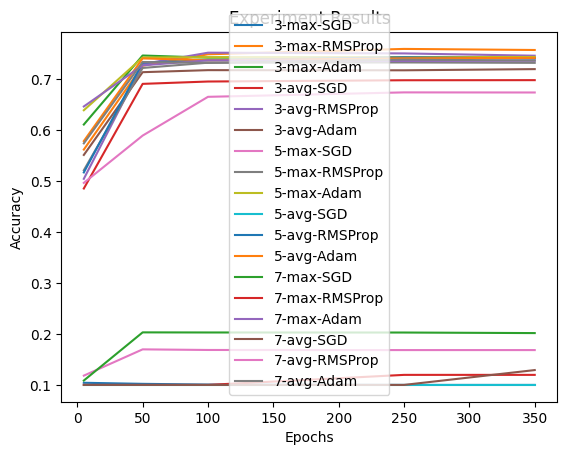

In [8]:
# 7. Visualize Results
for (kernel_size, pooling_type, opt_name), accuracies in results.items():
    plt.plot(num_epochs_list[:len(accuracies)], accuracies, label=f"{kernel_size}-{pooling_type}-{opt_name}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Experiment Results")
plt.legend()
plt.show()